# 6th Tutorial MD - Radial Distribution Function and Scattering Function

Using LAMMPS we will simulate a single chain and a melt of chains and calculate their radial distribution function (RDF) using our own Python code. Then we will Fourier transform the RDF to obtain the scattering function of the system. You can use this code here after finishing the simulation and writing a LAMMPS dump file containing the (wrapped) coordinates.

### 1. Simulate your system of choice and create a dump file "wrapped.txt" with the system coordinates at different times. Locate it in the same folder as thig script

### 2.  Read in the file "wrapped.txt" containing trajectory of the system. First, take a look at the format of the file - what information is stored in what lines? After reading in the fold, the trajectory of the melt should be stored in a numpy array (Hint: Read it line by line). Here, we use the same code as in the 2nd tutorial on MD.

In [21]:
# import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math 
import pandas as pd

%matplotlib inline
#%%time

# define some empty lists to store data
coords = []
ts_long = []
ts_real = []

# read in file line by line
filename = 'wrapped.txt'
ts = 0 # steps stored
read_timestep = False

# simulation parameters that are not stored in this file
dt = 0.005 # actual time step in LJ units

with open(filename) as fn:
    for i, row in enumerate(fn):

        # read in coordinates
        if len(row.split(' ')) == 7:
            row + str(ts)
            coords.append(row.split(' ')[:-1])
            ts_long.append(ts)

        # let's also get some extra info
        if i == 3:
            N = int(row)
        if i == 5:
            xdim = row.split(' ')
        if i == 6:
            ydim = row.split(' ')
        if i == 7:
            zdim = row.split(' ')
        if read_timestep == True:
            ts_real.append(np.float(row))
            read_timestep = False
        if 'TIMESTEP' in row:
            ts += 1
            read_timestep = True

# calculate the system density too maybe
coords = np.array(coords, dtype=float)   

**Now, after reading the file, let's extract some of the basic parameters and print them.**

In [22]:
# get the number of snapshots of the trajectory
steps = int(np.shape(coords)[0]/N)  

# Box size
xdim = np.array(xdim, dtype=float)
ydim = np.array(ydim, dtype=float)
zdim = np.array(zdim, dtype=float)
Lx = xdim[1]-xdim[0]
Ly = ydim[1]-ydim[0]
Lz = zdim[1]-zdim[0]

V = (xdim[1]-xdim[0]) * (ydim[1]-ydim[0]) * (zdim[1]-zdim[0])

print("Box size:")
print("x=(",xdim[0], ", ", xdim[1], ")")
print("y=(",ydim[0], ", ", zdim[1], ")")
print("z=(",zdim[0], ", ", zdim[1], ")")
print("Box volume = ", V)

## extract a couple of values we could use
Natoms_alt = np.max(coords[:,0])
Nmol = int(np.max(coords[:,1]))
N_per_chain = int(N/Nmol)
Ntypes = np.max(coords[:,2])
rho = N/V
delta_steps = ts_real[1] - ts_real[0]

print("Nr. of time steps = ", steps)
print("Time step increment between snapshots = ", delta_steps)
print("Time simulated [LJ units] = ", ts_real[-1]*dt)
print("Nr. of atoms = ", N)
print("Nr. of molecules = ", Nmol)
print("Nr of atoms / chain =",  N_per_chain)
print("Nr. of atom types =", Ntypes)
print("Total monomer (number) density =", rho)

Box size:
x=( 0.0 ,  100.0 )
y=( 0.0 ,  100.0 )
z=( 0.0 ,  100.0 )
Box volume =  1000000.0
Nr. of time steps =  101
Time step increment between snapshots =  10000.0
Time simulated [LJ units] =  5000.0
Nr. of atoms =  100
Nr. of molecules =  1
Nr of atoms / chain = 100
Nr. of atom types = 1.0
Total monomer (number) density = 0.0001


<center>(Image source: http://isaacs.sourceforge.net/manual/page23_ct.html)</center>
<img src="img/rdf.png" width=200 />

Next, we will calculate the RDF. This follows the same scheme as in the 2nd MD exercise but I think it is important to do this once in detail and with some more time. 

The RDF essentially is a histogram of particles j surrounding particle i at distance r. We also need to choose the correct normalization: The RDF compares the local system density with the density of an ideal gas of the same total density.


### 3. Iterate through the coordinates step by step and calculate the radial distribution function g(r). Then plot it and save it to a file.

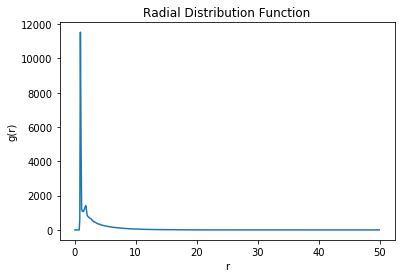

In [23]:
# this code only works for a cubic box, so let's check this first
if (Lx == Ly == Lz):
    L = Lx
else:
    print("Box is not cubic!")

# INITIALIZING CALCULATION
# ...    

# CALCULATE g(r) AT THE CURRENT SNAPSHOT
for t in range(steps):
    
    # get current coordinates of snapshot
    #....

    # allocate space for the "instantaneous" g(r)
    #....       

    # we need to consider all pairs of atoms (i and j that are not equal)
    #....

    # enforce minimum image convention
    #....

    # get absolute distances of all pairs
    #....
    
    # ignore pairs that are further than half a box length
    #....

    # binning the data = generate the histogram
    #....
            
    # add the "instantaneous" g(r) to the total g(r), later average it        
    #....


# average the data and normalize the bins
for j in range(gbins):

    # normalize by number of samples, number of particles
    # and number of ideal gas particles in the jth shell,
    # jth shell = the volume between bin j and bin j+1 = sphere shell of thickness "binsz"
    #....

# plot and save to a file
#....

# save values to a file
#....

For a system filled with particles the RDF always goes to 1 for large values of r, e.g. for a melt, a gas etc. 
This is a typical RDF of a melt of chains:

<img src="img/rdf_melt.png" width=600 />


**Let's get the Scattering function S(q) - it is the Fourier transform of g(r).**

We can calculate the Scattering function in MD either directly by scattering "light beams" on the particles and recording the resulting function, or by Fourier transforming the RDF. It is instructive to do this by the following formula:

\begin{equation}
S(q) = 1 + 4 \pi \rho \int_0^\infty r (g(r) -1 ) \frac{\sin{qr}}{q} dr.
\end{equation}

We can discretize this integral and apply it to our data.

### 3. In the following, we create the code to Fourier transform the RDF to get S(q).

In [1]:
print("rho = ", rho)

## OPTIONAL: read in rdf file with g(r)
#rdf_filename='rdf.txt'
#data = np.loadtxt(rdf_filename, skiprows=1)
#r = data[:,1]
#g = data[:,2]

r = gbin_center

# calculate r bins
#....

# calculate q bins
#....

# maximum and minimum q value and increment
#....

q = np.zeros(N_qbins)
S = np.zeros(N_qbins)

# perform Fourier Transform from r to q space (Integral, see above)
for i in range(N_qbins):
    #....

# write S(q) to file
#....

# plot S(q)
#....


SyntaxError: unexpected EOF while parsing (<ipython-input-1-3b497300b434>, line 31)

This method of getting the Scattering function S(q) is very fast and easily available when you also have the RDF. If you ever need S(q) of your system it is still advisable to directly calulcate it, even though this is much slower and computationally expensive. The direct calculation can have more noise but it delivers more accurate results for small values of q. In this range (small q) the Fourier transformed S(q) has more errors because the errors of the RDF for large r are having a strong influence there.

<center>Comparison of S(q) obtained by Fourier transform of the RDF or by direct calculation (single chain in good solvent):</center>
<img src="img/compare_s.png" width=600 />

<center>Comparison of S(q) obtained by Fourier transform of the RDF or by direct calculation (single chain in poor solvent):</center>
<img src="img/compare_s_poor.png" width=600 />